In [45]:
# %% Cell 1: Import libraries
import os
import numpy as np
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio.mask



print("✅ Libraries imported successfully")



✅ Libraries imported successfully


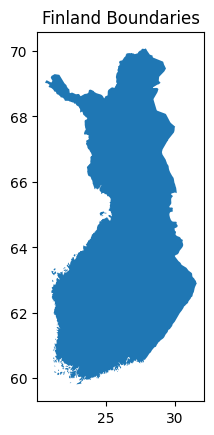

In [50]:
# Load the Finland shapefile (Update the path if needed)
finland_shp = gpd.read_file("/Data/fi_shp/fi.shp")

# Ensure it's in the same CRS as your temperature raster
finland_shp = finland_shp.to_crs("EPSG:4326")

# Display the shapefile to verify
finland_shp.plot()
plt.title("Finland Boundaries")
plt.show()

In [ ]:
def clip_raster_to_shapefile(raster_path, shapefile, output_path):
    with rasterio.open(raster_path) as src:
        # Convert the shapefile geometry into rasterio format
        shapes = [shapefile.geometry.unary_union.__geo_interface__]

        # Clip the raster using the mask function
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta.copy()

        # Update metadata to match the clipped image
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        # Save the clipped raster
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

        print(f"✅ Clipped and saved: {output_path}")

# Example usage:
clip_raster_to_shapefile("/Data/temperature.tif", finland_shp, "data/clipped_temperature.tif")

✅ Clipped and saved: clipped_temperature.tif


C:\Users\abdel\AppData\Local\Temp\ipykernel_19664\3625169082.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  shapes = [shapefile.geometry.unary_union.__geo_interface__]


In [53]:
# %% Cell 4: Configuration
# Input directory containing your GeoTIFF files
geotiff_file = "/Data/clipped_temperature.tif"  # Update this path
finland_shapefile = "/Data/fi_shp/fi.shp"  # Update this path
output_gif = "temperature_animation.gif"
temp_image_dir = "temp_images"


In [54]:
# Create directories if they don't exist
os.makedirs(temp_image_dir, exist_ok=True)

print("⚙️ Configuration set:")
print(f"- GeoTIFF file: {geotiff_file}")
print(f"- Shapefile: {finland_shapefile}")
print(f"- Output GIF: {output_gif}")

⚙️ Configuration set:
- GeoTIFF file: C:/Users/abdel/OneDrive/Desktop/Tomkulak/Data/clipped_temperature.tif
- Shapefile: C:/Users/abdel/OneDrive/Desktop/Tomkulak/Data/fi_shp/fi.shp
- Output GIF: temperature_animation.gif


In [56]:
# %% Cell 6: Load Shapefile and Raster Data
print("🔍 Loading Finland shapefile...")

try:
    # Load the shapefile using geopandas
    finland_gdf = gpd.read_file(finland_shapefile)
    print("✅ Shapefile loaded successfully!")
    print("Here's a preview of the shapefile data:")
    print(finland_gdf.head())
except Exception as e:
    print("❌ Error loading shapefile:")
    print(e)
    raise

print("\n🔍 Loading GeoTIFF temperature data...")

try:
    # Open the GeoTIFF file using rasterio
    raster = rasterio.open(geotiff_file)
    print("✅ GeoTIFF loaded successfully!")
    print("Raster information:")
    print(" - Coordinate Reference System (CRS):", raster.crs)
    print(" - Raster bounds:", raster.bounds)
    print(" - Number of bands (assumed time steps):", raster.count)
except Exception as e:
    print("❌ Error loading GeoTIFF:")
    print(e)
    raise


🔍 Loading Finland shapefile...
✅ Shapefile loaded successfully!
Here's a preview of the shapefile data:
   id     name                  source  \
0  FI  Finland  https://simplemaps.com   

                                            geometry  
0  MULTIPOLYGON (((28.95408 69.02726, 28.83346 68...  

🔍 Loading GeoTIFF temperature data...
✅ GeoTIFF loaded successfully!
Raster information:
 - Coordinate Reference System (CRS): None
 - Raster bounds: BoundingBox(left=20.55, bottom=59.75, right=31.55, top=70.05)
 - Number of bands (assumed time steps): 252


In [57]:
# %% Cell 7: Process Temperature Data and Save Frames (with debug info)
import pandas as pd  # for creating date range
from matplotlib.colors import Normalize

print("📅 Creating date range for temperature bands...")
# Create a date range with monthly frequency, assuming each band is one month.
dates = pd.date_range(start="2004-01-01", periods=raster.count, freq="MS")  # 'MS' means Month Start
print(f"✅ Date range created with {len(dates)} timestamps.")

print("\n🔄 Reprojecting shapefile to WGS84 (EPSG:4326) for overlay...")
try:
    # Convert the shapefile to WGS84 so that it aligns with our raster (which uses geographic coordinates)
    finland_gdf_wgs84 = finland_gdf.to_crs(epsg=4326)
    print("✅ Shapefile reprojected successfully!")
except Exception as e:
    print("❌ Error reprojecting shapefile:")
    print(e)
    raise

# Define normalization for temperature display (in Celsius)
# For Finland, a range from -30°C to +30°C is a reasonable guess.
vmin, vmax = -30, 30

print("\n🖼️ Processing each band to create frames for the animation...")

# Loop over each band in the raster
for band in range(1, raster.count + 1):
    print(f"\nProcessing band {band}/{raster.count}...")
    
    try:
        # Read the band data from the raster. Ensure the data is float for temperature conversion.
        temp_data = raster.read(band).astype(float)
    except Exception as e:
        print(f"❌ Error reading band {band}:")
        print(e)
        continue
    
    # Convert temperature from Kelvin to Celsius
    temp_data_celsius = temp_data

    # Debug: print the min and max temperature for this band
    band_min = np.nanmin(temp_data_celsius)
    band_max = np.nanmax(temp_data_celsius)
    print(f"   Temperature range for band {band}: {band_min:.2f}°C to {band_max:.2f}°C")
    
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(8, 6))
    
    # Plot the temperature data using imshow
    img = ax.imshow(
        temp_data_celsius,
        cmap='coolwarm',
        extent=(raster.bounds.left, raster.bounds.right, raster.bounds.bottom, raster.bounds.top),
        origin='upper',
        norm=Normalize(vmin=vmin, vmax=vmax)
    )
    
    # Overlay the Finland shapefile boundaries
    finland_gdf_wgs84.boundary.plot(ax=ax, color='black', linewidth=1)
    
    # Add a title with the corresponding date
    ax.set_title(f"Temperature Pattern - {dates[band-1].strftime('%Y-%m')}")
    
    # Add a colorbar to show the temperature scale
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', label='Temperature (°C)')
    
    # Remove axis ticks for clarity
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the current frame as a PNG image
    frame_filename = os.path.join(temp_image_dir, f"frame_{band:03d}.png")
    try:
        plt.savefig(frame_filename, bbox_inches='tight')
        print(f"✅ Saved frame: {frame_filename}")
    except Exception as e:
        print(f"❌ Error saving frame {band}:")
        print(e)
    
    # Close the figure to free memory
    plt.close(fig)

print("\n🎉 All frames processed and saved successfully!")


📅 Creating date range for temperature bands...
✅ Date range created with 252 timestamps.

🔄 Reprojecting shapefile to WGS84 (EPSG:4326) for overlay...
✅ Shapefile reprojected successfully!

🖼️ Processing each band to create frames for the animation...

Processing band 1/252...
   Temperature range for band 1: -15.66°C to 0.00°C
✅ Saved frame: temp_images\frame_001.png

Processing band 2/252...
   Temperature range for band 2: -14.89°C to 0.00°C
✅ Saved frame: temp_images\frame_002.png

Processing band 3/252...
   Temperature range for band 3: -9.18°C to 0.00°C
✅ Saved frame: temp_images\frame_003.png

Processing band 4/252...
   Temperature range for band 4: -4.35°C to 5.75°C
✅ Saved frame: temp_images\frame_004.png

Processing band 5/252...
   Temperature range for band 5: -0.64°C to 10.66°C
✅ Saved frame: temp_images\frame_005.png

Processing band 6/252...
   Temperature range for band 6: 0.00°C to 13.86°C
✅ Saved frame: temp_images\frame_006.png

Processing band 7/252...
   Temperat

In [ ]:
# %% Cell 8: Create GIF Animation from Frames with Updated Resampling
print("🎞️ Starting GIF creation process...")

# Use imageio.v2 to avoid deprecation warnings
import imageio.v2 as imageio
from PIL import Image

# List to hold file paths of the frame images
frame_files = []

# Get all PNG files from the temporary image directory and sort them
try:
    for filename in sorted(os.listdir(temp_image_dir)):
        if filename.endswith(".png"):
            frame_path = os.path.join(temp_image_dir, filename)
            frame_files.append(frame_path)
    print(f"✅ Found {len(frame_files)} frame images.")
except Exception as e:
    print("❌ Error accessing frame images:")
    print(e)
    raise

# Check if there are any frames to process
if not frame_files:
    raise FileNotFoundError("No frame images were found in the temporary directory.")

# Read the first image to determine the target shape (width, height)
try:
    with Image.open(frame_files[0]) as img:
        target_size = img.size  # (width, height)
    print(f"🎯 Target size for all frames: {target_size}")
except Exception as e:
    print("❌ Error reading the first frame to determine target size:")
    print(e)
    raise

# Read all frames, resizing them if necessary, and store them in a list
frames = []
for frame_file in frame_files:
    try:
        # Open the image using Pillow
        with Image.open(frame_file) as img:
            # Resize if the image size doesn't match the target
            if img.size != target_size:
                img = img.resize(target_size, resample=Image.LANCZOS)
            # Convert the image to a numpy array
            frame_array = np.array(img)
            frames.append(frame_array)
    except Exception as e:
        print(f"❌ Error processing frame {frame_file}:")
        print(e)

print("✅ All frames loaded and resized successfully. Creating GIF...")

# Create the GIF using imageio
try:
    # 'duration' controls the time (in seconds) each frame is shown (0.2 seconds here)
    imageio.mimsave(output_gif, frames, duration=0.2)
    print(f"🎉 GIF created successfully and saved as '{output_gif}'!")
except Exception as e:
    print("❌ Error creating GIF:")
    print(e)
    raise


🎞️ Starting GIF creation process (Revised)...
✅ Found 252 frame images.
🎯 Target size for all frames: (365, 512)
✅ All frames loaded and resized successfully. Creating GIF...
🎉 GIF created successfully and saved as 'temperature_animation.gif'!
